In [27]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
with open("normalized_names.txt") as f:
    text = [line.lower().strip('\n ') for line in f]
    
strain_names = []
for t in text:
    if ',' in t:
        strain_names.extend(t.split(','))
    else:
        strain_names.append(t)

In [4]:
all_letters = "".join({ch for name in strain_names for ch in name})
n_letters = len(all_letters) + 1 # Plus EOS marker


# Build the category_lines dictionary, a list of lines per category
category_lines = {'strain': strain_names}
all_categories = ['strain']
n_categories = 1

print('# categories:', n_categories, all_categories)

# categories: 1 ['strain']


In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [13]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [14]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [15]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

In [22]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i].unsqueeze(0))

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data.item() / input_line_tensor.size()[0]

In [23]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 500
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

/Users/rpugh/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 2s (500 0%) 3.2943
0m 5s (1000 1%) 3.3918
0m 8s (1500 1%) 2.9768
0m 11s (2000 2%) 2.9372
0m 14s (2500 2%) 3.4075
0m 16s (3000 3%) 2.8780
0m 20s (3500 3%) 2.8553
0m 23s (4000 4%) 3.8735
0m 26s (4500 4%) 3.0785
0m 29s (5000 5%) 2.9920
0m 32s (5500 5%) 2.9987
0m 35s (6000 6%) 3.2267
0m 38s (6500 6%) 3.2677
0m 41s (7000 7%) 3.0167
0m 44s (7500 7%) 2.9308
0m 47s (8000 8%) 2.5827
0m 50s (8500 8%) 2.5653
0m 53s (9000 9%) 2.8178
0m 57s (9500 9%) 3.2522
1m 0s (10000 10%) 2.4971
1m 3s (10500 10%) 2.5610
1m 6s (11000 11%) 2.7977
1m 9s (11500 11%) 2.7241
1m 12s (12000 12%) 2.3465
1m 15s (12500 12%) 3.6967
1m 18s (13000 13%) 2.6103
1m 21s (13500 13%) 2.3957
1m 24s (14000 14%) 3.0658
1m 27s (14500 14%) 2.8593
1m 30s (15000 15%) 2.5587
1m 33s (15500 15%) 2.6310
1m 36s (16000 16%) 3.1765
1m 39s (16500 16%) 2.3236
1m 42s (17000 17%) 3.5669
1m 45s (17500 17%) 3.3069
1m 48s (18000 18%) 3.0361
1m 51s (18500 18%) 2.2734
1m 54s (19000 19%) 3.1923
1m 57s (19500 19%) 3.1768
2m 0s (20000 20%) 2.2544
2m 3s (

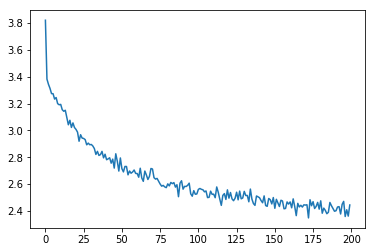

In [28]:
plt.figure()
plt.plot(all_losses)

In [120]:
max_length = 100

# Sample from a category and starting letter
def sample(category='strain', start_letter='A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category='strain', start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [124]:
for _ in range(10):
    starting_letter = 'abcdefghijklmnopqrstuvwxyz'
    samples(start_letters=random.choice(starting_letter))

emondawger plant
emon canes
shand wgete
dawgere
alitan burbyer
og kush
dambe bubble
oricana cheese
kush
laman where sianal


/Users/rpugh/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
